# Dissertation Modelling - preprocessing + ANN + RF + SHAP


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving popa_et_al_2021_wt%_RAI(mol%)_K#(mol%).xlsx to popa_et_al_2021_wt%_RAI(mol%)_K#(mol%).xlsx


In [ ]:
# Import data from excel

import pandas as pd

DG_path = "/content/DiGenova_database_wt%_RAI(mol%)_K#(mol%).xlsx"
Popa_path = "/content/popa_et_al_2021_wt%_RAI(mol%)_K#(mol%).xlsx"

DG_workbook = pd.read_excel(DG_path, sheet_name = None, engine = "openpyxl")
Popa_workbook = pd.read_excel(Popa_path, sheet_name = None, engine = "openpyxl")

# Now workbooks stored in these variables



In [ ]:
# ## Accessing sheets

# ## Di Genova

FMQ_DG_df = DG_workbook["FMQ"]



In [ ]:
# ## Popa

FMQ_popa_df = Popa_workbook["FMQ"]


In [ ]:
# Extracting colnames for both data sets to see which columns they have in common:

FMQ_DG_columns = FMQ_DG_df.columns.tolist()
FMQ_popa_columns = FMQ_popa_df.columns.tolist()
FMQ_DG_columns_df = pd.DataFrame(FMQ_DG_columns, columns=['Di Genova Variables'])
FMQ_popa_columns_df = pd.DataFrame(FMQ_popa_columns, columns=['Popa Variables'])



In [ ]:
# Finding number of missing values per column (encoded as 0s in data set), for both data sets

# DG

missing_values_per_column_DG = FMQ_DG_df.apply(lambda x: (x==0).sum(), axis=0)
missing_values_df_DG = pd.DataFrame(missing_values_per_column_DG, columns=['Number of missing values'])
missing_values_df_DG['Proportion (%)'] = (missing_values_per_column_DG / FMQ_DG_df.shape[0])*100

print(missing_values_df_DG)


In [ ]:



# Popa missing values after removal of rows

missing_values_per_column_popa = FMQ_popa_df.apply(lambda x: (x==0).sum(), axis=0)
missing_values_df_popa = pd.DataFrame(missing_values_per_column_popa, columns=['Number of missing values'])
missing_values_df_popa['Proportion'] = (missing_values_per_column_popa / FMQ_popa_df.shape[0])*100

print(missing_values_df_popa)


In [ ]:
## Add eruptive_type binary column and move variables to global environment


DG_list_initial = [FMQ_DG_df]

# Step 2: Add the "eruptive_type" column to each DataFrame
# Loop through  add the new column
for df in DG_list_initial:
    # Create a new column with 0s for the first 571 rows, and 1s for the rest
    df['eruptive_type'] = [0] * 571 + [1] * (len(df) - 571)


# Step 4: Remove columns
columns_to_remove = [0, 2, 3, 9, 12, 15, 16, 17, 18] # taken out col 1 from removal

for df in DG_list_initial:
    df.drop(columns=df.columns[columns_to_remove], axis=1, inplace=True)

# Step 5: Assign DataFrame to global environment
for i, df in enumerate(DG_list_initial):
    globals()[f'df{i+1}'] = df




In [ ]:
# Now DG dataset in right form. Do the same for Popa


Popa_list_initial = [FMQ_popa_df]


for df in Popa_list_initial:
    # Use the apply() function with a lambda function to map "effusive" to 0 and "explosive" to 1
    df['eruptive_type'] = df['Eruptive style'].apply(lambda x: 0 if x == 'effusive' else 1)


columns_popa_remove = [1,2,3,4,5,15] # taken out col 0 from removal (see top of code script)


for df in Popa_list_initial:
    df.drop(columns=df.columns[columns_popa_remove], axis=1, inplace=True)

# Step 5: Assign DataFrames to global environment
for i, df in enumerate(Popa_list_initial):
    globals()[f'df{i+1}'] = df


In [ ]:
# Renaming first column of Popa data set so that df in right form to be concatenated with DG

FMQ_popa_df.rename(columns={'Volcano and Eruption': 'Volcano'}, inplace=True)

In [ ]:
# Now data sets in right form to be concatenated

combined_FMQ_df = pd.concat([FMQ_DG_df, FMQ_popa_df], axis=0,ignore_index = True)



In [ ]:
# Data frame of missing values in combined FMQ data set

missing_values_per_column_combined = combined_FMQ_df.apply(lambda x: (x==0).sum(), axis=0)
missing_values_df_combined = pd.DataFrame(missing_values_per_column_combined, columns=['Number of missing values'])
missing_values_df_combined['Proportion (%)'] = (missing_values_per_column_combined / combined_FMQ_df.shape[0])*100

print(missing_values_df_combined)



In [ ]:
# Removing rows which have variables that take a value of 0 i.e missing values

# Select all columns except the last one and check if any of them are equal to 0
zero_in_columns_FMQ = combined_FMQ_df.iloc[:, :-1].eq(0).any(axis=1)

# Keep only the rows where none of the selected columns have a value of 0
combined_FMQ_clean_RANGE_df = combined_FMQ_df.loc[~zero_in_columns_FMQ]

# Reset index to align properly with stored columns
combined_FMQ_clean_RANGE_df.reset_index(drop=True, inplace=True)


In [ ]:
combined_FMQ_clean_RANGE_df.shape

# Ends up being 41 observations removed

(1137, 13)

In [ ]:
# Producing dataframes that can be imported into R


R_combined_FMQ_clean_RANGE_df = combined_FMQ_clean_RANGE_df
R_combined_FMQ_clean_RANGE_df.to_csv('python_combined_FMQ.csv', index=False)
from google.colab import files

files.download('python_combined_FMQ.csv')









<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install clr package

!pip install scikit-bio

In [ ]:
# Import

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.composition import clr

In [ ]:
!pip install shap

In [ ]:
# SHAP analysis for clr-transformed data set with logistic regression model

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# Trying to see which volcanoes/volcanic systems dominate the data


volcano_counts = combined_FMQ_clean_RANGE_df.groupby('Volcano').size().reset_index(name='Number of Observations')

# Sort the dataframe by 'Number of Observations' in descending order to see which volcanoes are most prevalent
volcano_counts_sorted = volcano_counts.sort_values(by='Number of Observations', ascending=False)

pd.set_option('display.max_rows', None)
# Display the sorted dataframe
print(volcano_counts_sorted)





In [ ]:
import pandas as pd



def consolidate_volcano_names(name):
    # A list of keywords for each major volcano
    volcanoes = ["Yellowstone", "Santiaguito", "Niijima", "Torfajokull", "Cordon Caulle", "Colima", "Crater Lake",
                 "Dominica Island", "Altiplano-Puna", "Aniakchak", "Apoyeque", "Aso", "Batur", "Bezymianny",
                 "Ceboruco", "Cerro Chascon", "Cerro Galan", "Cerro Machin", "Chaiten", "Ciomadul", "Medicine Lake",
                 "Methana", "Mono-Inyo", "Montserrat", "Mt Saint Helens", "Mt Spurr", "Mt. Dutton", "Mt. Erciyes",
                 "Mt. Shasta", "Mangakino Volcanic Centre", "El Chicon", "Glass Mt and Long Valley", "Great Basin",
                 "Hekla", "Inyo Craters", "Katmai", "Kizimen", "Ksudach", "Kutcharo", "Lake Atitlan", "Lassen Volcanic Area",
                 "Lipari"]

    for volcano in volcanoes:
        if volcano in name:
            return volcano
    return name

# Apply the function to consolidate names
combined_FMQ_clean_RANGE_df['Consolidated_Volcano'] = combined_FMQ_clean_RANGE_df['Volcano'].apply(consolidate_volcano_names)

# Group by the new consolidated column and count the number of observations
consolidated_counts = combined_FMQ_clean_RANGE_df.groupby('Consolidated_Volcano').size().reset_index(name='Number of Observations').sort_values(by='Number of Observations', ascending=False)

print(consolidated_counts)


In [ ]:
# Filter, remove first and last columns, and reset index for Cordon Caulle
cordon_caulle_df = combined_FMQ_clean_RANGE_df[combined_FMQ_clean_RANGE_df['Consolidated_Volcano'] == 'Cordon Caulle']
cordon_caulle_df = cordon_caulle_df.iloc[:, 1:-1].reset_index(drop=True)

# Filter, remove first and last columns, and reset index for Yellowstone
yellowstone_df = combined_FMQ_clean_RANGE_df[combined_FMQ_clean_RANGE_df['Consolidated_Volcano'] == 'Yellowstone']
yellowstone_df = yellowstone_df.iloc[:, 1:-1].reset_index(drop=True)

# Filter, remove first and last columns, and reset index for Lipari
lipari_df = combined_FMQ_clean_RANGE_df[combined_FMQ_clean_RANGE_df['Consolidated_Volcano'] == 'Lipari']
lipari_df = lipari_df.iloc[:, 1:-1].reset_index(drop=True)


In [ ]:
# Non-yellowstone

# Filter out Yellowstone, remove first and last columns, and reset index
non_yellowstone_df = combined_FMQ_clean_RANGE_df[combined_FMQ_clean_RANGE_df['Consolidated_Volcano'] != 'Yellowstone']
non_yellowstone_df = non_yellowstone_df.iloc[:, 1:-1].reset_index(drop=True)


In [ ]:
non_yellowstone_df.to_csv('non_yellowstone.csv', index=False)

In [ ]:
from google.colab import files

files.download('non_yellowstone.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Import different dfs into R for post-modelling EDA

cordon_caulle_df.to_csv('cordon_caulle.csv', index=False)
yellowstone_df.to_csv('yellowstone.csv', index=False)
lipari_df.to_csv('lipari.csv', index=False)


In [ ]:
from google.colab import files

files.download('cordon_caulle.csv')
files.download('yellowstone.csv')
files.download('lipari.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
unique_volcanoes_cleaned = combined_FMQ_clean_RANGE_df.iloc[:, 0].unique()
 # print(unique_volcanoes_cleaned)

 # Now clean list further to remove duplictes + include manual addition

unique_volcanoes_cleaned_2 = set()
for name in unique_volcanoes_cleaned:
    main_name = name.split(",")[0].split("(")[0].strip()
    unique_volcanoes_cleaned_2.add(main_name)

# Sort for easier reading
sorted_volcanoes = sorted(list(unique_volcanoes_cleaned_2))

print(sorted_volcanoes)

In [ ]:
cleaned_volcanoes = [
    'Yellowstone',
    'Lipari',
    'Newberry',
    'Vulcano',
    'Douglas Knob',
    'Cordon Caulle',
    'Milos',
    'Mt Jemez (USA)',
    'Obsidian (MX)',
    'Mt Edziza',
    'Askja',
    'Torfajokull',
    'Hrafntinnuhryggur',
    'Easter Islands',
    'Okataina (NZ)',
    'Mono-Inyo',
    'Glass Mountain (USA)',
    'Medicine Lake',
    'Panum Craters',
    'Chaiten',
    'Cerro Galan',
    'Santorini',
    'Kos Plateau',
    'Taupo',
    'Mt Katmai',
    'Bishop Tuff',
    'Mt Pinatubo',
    'Tarawera',
    'Toluca',
    'Oraefajokull',
    'El Chichon',
    'Montserrat',
    'Nisyros',
    'Yali',
    'Methana',
    'Mt. Erciyes',
    'Ciomadul',
    'Hekla',
    'Thingmuli',
    'Bezymianny',
    'Kizimen',
    'Katmai',
    'Ksudach',
    'Aniakchak',
    'Mt Spurr',
    'Mt. Dutton',
    'Mt Staint Helens',
    'Mt. Shasta',
    'Lassen Volcanic Area',
    'San Juan Volcanic Field',
    'Crater Lake, Oregon',
    'Inyo Craters',
    'Great Basin',
    'Toquima range, Nevada',
    'Popocatepetl',
    'Los Humeros',
    'Colima',
    'Ceboruco',
    'Tequila',
    'San Antonio, Tacana',
    'Santa Maria',
    'Santiaguito',
    'Lake Atitlan',
    'Pacaya',
    'Apoyeque',
    'Cerro Machin',
    'Quilotoa',
    'Andes, Bolivia',
    'Altiplano, South America',
    'Nevado de Longavi',
    'Quizapu',
    'Dominica Island',
    'Unzen',
    'Kutcharo',
    'Aso',
    'Niijima',
    'Ruapehu',
    'Tauhara volcano',
    'Tongariro',
    'Okataina Volcanic Center',
    'Mangakino Volcanic Centre',
    'Galunggung',
    'Rinjani',
    'Batur',
    'Pinatubo'
]


In [ ]:

# !pip install googlemaps

import googlemaps
from getpass import getpass
import pandas as pd

# Enter your API key securely
API_KEY = getpass("API Key here: ")

gmaps = googlemaps.Client(key=API_KEY)


latitudes = []
longitudes = []

for name in cleaned_volcanoes:
    print(f"Fetching coordinates for {name}...")
    geocode_result = gmaps.geocode(name + " volcano")
    if geocode_result:
        latitudes.append(geocode_result[0]["geometry"]["location"]["lat"])
        longitudes.append(geocode_result[0]["geometry"]["location"]["lng"])
    else:
        print(f"Failed to fetch coordinates for {name}.")
        latitudes.append(None)
        longitudes.append(None)

df_volcano_coords = pd.DataFrame({
    'name': cleaned_volcanoes,
    'latitude': latitudes,
    'longitude': longitudes
})

print(df_volcano_coords)


In [ ]:
# Now have df with lats + longs for volcanoes
!pip install geopandas



In [ ]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt


<ipython-input-66-840990c62d14>:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


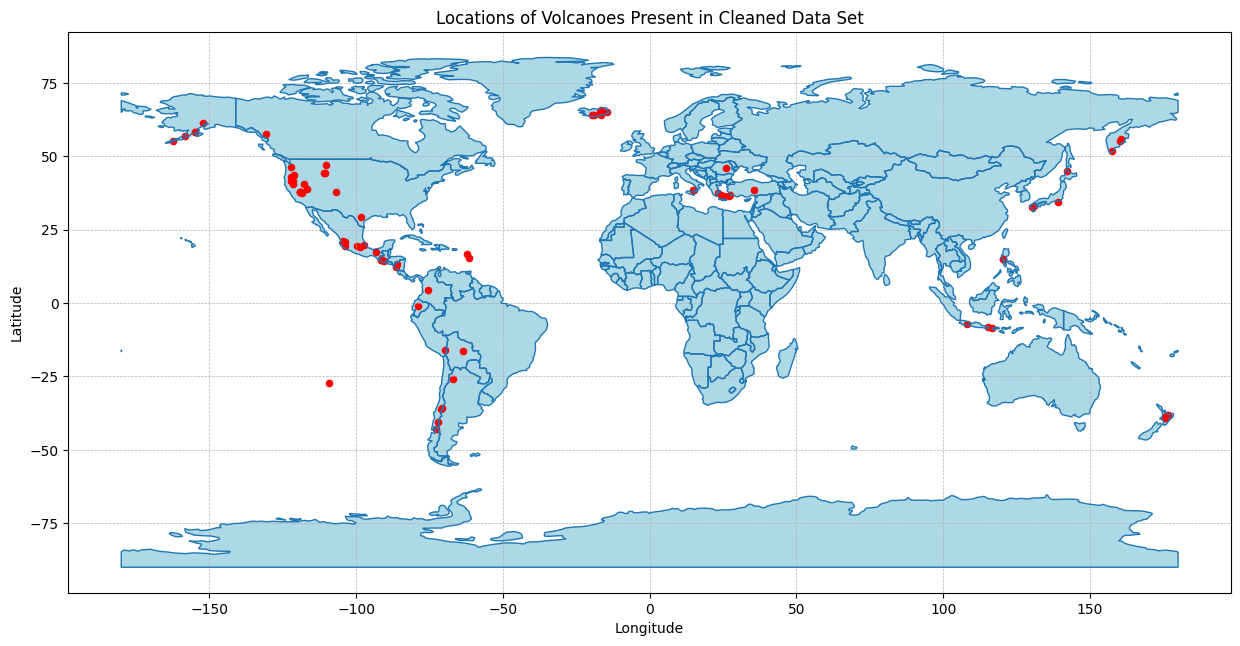

In [ ]:
# Create a GeoDataFrame from your DataFrame
gdf = gpd.GeoDataFrame(df_volcano_coords_clean, geometry=gpd.points_from_xy(df_volcano_coords_clean.longitude, df_volcano_coords_clean.latitude))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

# Use Geopandas to plot the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(ax=ax, color='lightblue')

# Plot the volcano locations
gdf.plot(ax=ax, color='red', markersize=20)

# Adjust plot settings and display
plt.title('Locations of Volcanoes Present in Cleaned Data Set')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('volcano_map.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Remove "Volcano" column before performing CLR and conslidated column

combined_FMQ_clean_RANGE_df.drop(combined_FMQ_clean_RANGE_df.columns[0], axis = 1, inplace = True)


# combined_FMQ_clean_RANGE_df.drop(combined_FMQ_clean_RANGE_df.columns[-1], axis = 1, inplace = True) << uncomment if including consilidated





A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Perform CLR

# Now need to also apply centered log ratio transformation to compositional data, (so not on
# RAI, K# and eruptive_type columns)

import pandas as pd
import numpy as np
from skbio.stats.composition import clr


# Store the columns "K#", and "eruptive_type" and "RAI"
RAI_column_FMQ = combined_FMQ_clean_RANGE_df["RAI(mol%)"]
k_column_FMQ = combined_FMQ_clean_RANGE_df["K#(mol%)"]
eruptive_type_column_FMQ = combined_FMQ_clean_RANGE_df["eruptive_type"]

# Drop the columns "K#", and "eruptive_type" and "RAI" from the DataFrame
combined_FMQ_clean_RANGE_df.drop(columns=["RAI(mol%)","K#(mol%)", "eruptive_type"], inplace=True)

# Perform CLR transformation on the DataFrame (assuming all other columns are compositional data)
clr_transformed_data_FMQ = clr(combined_FMQ_clean_RANGE_df.values)

# Convert the transformed data back to a DataFrame
combined_FMQ_clr_transformed_df_RANGE = pd.DataFrame(clr_transformed_data_FMQ, columns=combined_FMQ_clean_RANGE_df.columns)

# Add back the columns "RAI", "K#", and "eruptive_type" to the DataFrame
combined_FMQ_clr_transformed_df_RANGE["RAI(mol%)"] = RAI_column_FMQ
combined_FMQ_clr_transformed_df_RANGE["K#(mol%)"] = k_column_FMQ
combined_FMQ_clr_transformed_df_RANGE["eruptive_type"] = eruptive_type_column_FMQ


In [ ]:
# SHAP analysis, logistic regression, FMQ

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import shap


In [ ]:
# Preparing to train logistic regression classifier

X_clr_FMQ = combined_FMQ_clr_transformed_df_RANGE.iloc[:, :-1]  # Features
y_clr_FMQ = combined_FMQ_clr_transformed_df_RANGE.iloc[:, -1]  # Target variable

# Split data into training and test (80-20 split)

X_train_clr_FMQ, X_test_clr_FMQ, y_train_clr_FMQ, y_test_clr_FMQ = train_test_split(X_clr_FMQ, y_clr_FMQ, test_size=0.2, random_state=42)



In [ ]:
# Standardise data since K# probably on different scale to compositional data since did not undergo
# clr

scaler_clr_FMQ = StandardScaler()
X_train_scaled_clr_FMQ = scaler_clr_FMQ.fit_transform(X_train_clr_FMQ)
X_test_scaled_clr_FMQ = scaler_clr_FMQ.transform(X_test_clr_FMQ)



In [ ]:
# Train logistic regression model
tf.random.set_seed(42)
model_logr_clr_FMQ = LogisticRegression(random_state=42)
model_logr_clr_FMQ.fit(X_train_scaled_clr_FMQ, y_train_clr_FMQ)

# Evaluate model

y_pred_clr_FMQ = model_logr_clr_FMQ.predict(X_test_scaled_clr_FMQ)
print("Accuracy: %.4f" % accuracy_score(y_test_clr_FMQ, y_pred_clr_FMQ))


In [ ]:
# Create a SHAP explainer
explainer_clr_FMQ = shap.LinearExplainer(model_logr_clr_FMQ, X_train_scaled_clr_FMQ)

# Compute SHAP values for the test set
shap_values_clr_FMQ = explainer_clr_FMQ.shap_values(X_test_scaled_clr_FMQ)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

# Generate the SHAP summary plot on the defined axes
shap.summary_plot(shap_values_clr_FMQ, X_test_scaled_clr_FMQ, feature_names=X_clr_FMQ.columns.tolist(), plot_type="dot", show=False)

# Check the plot in Colab directly to ensure it looks as expected
plt.show()

fig.savefig('shap_logreg_final.png', dpi=300, bbox_inches='tight')

In [ ]:
from google.colab import files
files.download('shap_logreg_final.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Compute the mean absolute SHAP values for each feature
mean_abs_shap_values_clr_FMQ = np.mean(np.abs(shap_values_clr_FMQ), axis=0)

# Get the feature names
feature_names_clr_FMQ = X_clr_FMQ.columns.tolist()

# Create a DataFrame to hold the SHAP values and feature names
shap_df_clr_FMQ = pd.DataFrame(list(zip(feature_names_clr_FMQ, mean_abs_shap_values_clr_FMQ)), columns=['Feature','MeanAbsShap'])

# Sort the DataFrame by the mean absolute SHAP values
# shap_df_clr_FMQ = shap_df_clr_FMQ.sort_values(by='MeanAbsShap', ascending=True)

# Plot the vertical bar chart
plt.figure(figsize=(10,6))
plt.bar(shap_df_clr_FMQ['Feature'], shap_df_clr_FMQ['MeanAbsShap'], color='skyblue')
plt.ylabel('Mean Absolute SHAP Value')
plt.xlabel('Feature')
plt.title('Feature Importance')
plt.xticks(rotation=90) # Rotate the x-axis labels if they overlap
plt.title("Feature Importance, Logistic Regression")
plt.show()


In [ ]:


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import libraries for hyperparameter optimisation

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

tf.random.set_seed(42)

class KerasModelWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, build_fn=None, epochs=50, batch_size=32, verbose=0, callbacks=None,
                 validation_split=0.0, activation='relu', optimizer='adam', hidden_layer1_neurons=4,
                 hidden_layer2_neurons=4, hidden_layer3_neurons=4):

        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.callbacks = callbacks
        self.validation_split = validation_split
        self.activation = activation
        self.optimizer = optimizer
        self.hidden_layer1_neurons = hidden_layer1_neurons
        self.hidden_layer2_neurons = hidden_layer2_neurons
        self.hidden_layer3_neurons = hidden_layer3_neurons
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn(activation=self.activation, optimizer=self.optimizer,
                                   hidden_layer1_neurons=self.hidden_layer1_neurons,
                                   hidden_layer2_neurons=self.hidden_layer2_neurons,
                                   hidden_layer3_neurons=self.hidden_layer3_neurons)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose,
                       callbacks=self.callbacks, validation_split=self.validation_split)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=self.verbose)[1]  # Assuming that accuracy is the second metric

def create_model_FMQ(hidden_layer1_neurons=4, hidden_layer2_neurons=4, hidden_layer3_neurons=4,
                     optimizer='adam', activation='relu'):

    model = Sequential()
    model.add(Dense(hidden_layer1_neurons, input_dim=4, activation=activation))
    model.add(Dense(hidden_layer2_neurons, activation=activation))
    model.add(Dense(hidden_layer3_neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

skf_FMQ = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

param_grid = {
    'clf__hidden_layer1_neurons': [4, 32, 64, 128],
    'clf__hidden_layer2_neurons': [4, 16, 32, 64],
    'clf__hidden_layer3_neurons': [4, 8, 16, 32],
    'clf__optimizer': ['SGD', 'Adam'],
    'clf__activation': ['relu', 'tanh'],
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=4)),
    ('clf', KerasModelWrapper(build_fn=create_model_FMQ, epochs=50, batch_size=32,
                              callbacks=[early_stopping], validation_split=0.2, verbose=0))
])

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=skf_FMQ, n_jobs=-1)
grid_result = grid.fit(X_clr_FMQ, y_clr_FMQ)


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Results show best model is to use relu, 64,64,8 and adam optimizer


Best: 0.846943 using {'clf__activation': 'relu', 'clf__hidden_layer1_neurons': 128, 'clf__hidden_layer2_neurons': 64, 'clf__hidden_layer3_neurons': 16, 'clf__optimizer': 'Adam'}


In [ ]:
# Modifying code so that it does PCA within folds
from sklearn.decomposition import PCA

scaler_FMQ = StandardScaler()


skf_FMQ = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

class_report_NoReg_FMQ = []

def create_modelBuffer_NoReg():
    # Without regularization
    model_Buffer_NoReg = tf.keras.Sequential()
    model_Buffer_NoReg.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(4,))) # input shape = 4 since 4 PCs
    model_Buffer_NoReg.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model_Buffer_NoReg.add(tf.keras.layers.Dense(units=16, activation='relu'))
    model_Buffer_NoReg.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    # Compile model
    model_Buffer_NoReg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model_Buffer_NoReg

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
# Use this function to create a new instance of your model before each training run:
# model_FMQ_NoReg = create_modelBuffer_NoReg()

# Cross-Validation
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np


for train, test in skf_FMQ.split(X_clr_FMQ, y_clr_FMQ): # Note: Use original unscaled data here
    # 1. Split data
    X_train, X_test = X_clr_FMQ.iloc[train], X_clr_FMQ.iloc[test]
    y_train, y_test = y_clr_FMQ.iloc[train], y_clr_FMQ.iloc[test]

    # 2. Fit scaler and PCA on training data
    X_train_scaled = scaler_FMQ.fit_transform(X_train)
    X_test_scaled = scaler_FMQ.transform(X_test)  # Notice we use transform, not fit_transform

    pca_FMQ = PCA(n_components=4)
    X_train_pca = pca_FMQ.fit_transform(X_train_scaled)
    X_test_pca = pca_FMQ.transform(X_test_scaled) # Again, just transform

    # 3. Train the model on transformed training set
    model_FMQ_NoReg = create_modelBuffer_NoReg()
    model_FMQ_NoReg.fit(X_train_pca, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # 4. Evaluate on the transformed testing set
    y_pred_NoReg = model_FMQ_NoReg.predict(X_test_pca)
    y_pred1 = (y_pred_NoReg > 0.5).astype(int)

    report_NoReg = classification_report(y_test, y_pred1, output_dict=True)
    class_report_NoReg_FMQ.append(report_NoReg)



class0_metrics_NoReg_FMQ = [rep['0'] for rep in class_report_NoReg_FMQ]
class1_metrics_NoReg_FMQ = [rep['1'] for rep in class_report_NoReg_FMQ]

accuracy_NoReg_FMQ = [rep['accuracy'] for rep in class_report_NoReg_FMQ]

mean_class0_NoReg_FMQ = pd.DataFrame(class0_metrics_NoReg_FMQ).mean()
mean_class1_NoReg_FMQ = pd.DataFrame(class1_metrics_NoReg_FMQ).mean()

mean_accuracy_NoReg_FMQ = np.mean(accuracy_NoReg_FMQ)

print("Average metrics for Model FMQ NoReg, Class 0:\n", mean_class0_NoReg_FMQ)
print("Average metrics for Model FMQ NoReg, Class 1:\n", mean_class1_NoReg_FMQ)
print("Average accuracy for Model FMQ NoReg:\n", mean_accuracy_NoReg_FMQ)



In [ ]:
def create_modelBuffer_NoReg_clr():
    # Without regularization
    model_reduced_NoReg = tf.keras.Sequential()
    model_reduced_NoReg.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(11,)))
    model_reduced_NoReg.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model_reduced_NoReg.add(tf.keras.layers.Dense(units=16, activation='relu'))
    model_reduced_NoReg.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    # Compile model
    model_reduced_NoReg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model_reduced_NoReg

In [ ]:
# SHAP for FMQ data

tf.random.set_seed(42)

# Train the artificial neural network
model_FMQ_NoReg_clr = create_modelBuffer_NoReg_clr()
model_FMQ_NoReg_clr.fit(X_train_scaled_clr_FMQ, y_train_clr_FMQ, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# Evaluate the model
y_pred_clr_FMQ_ANN = (model_FMQ_NoReg_clr.predict(X_test_scaled_clr_FMQ) > 0.5).astype(int)
print("Accuracy: %.4f" % accuracy_score(y_test_clr_FMQ, y_pred_clr_FMQ_ANN))





In [ ]:
# Create a SHAP explainer
explainer_clr_FMQ_ANN = shap.DeepExplainer(model_FMQ_NoReg_clr, X_train_scaled_clr_FMQ)

# Compute SHAP values for the test set
shap_values_clr_FMQ_ANN = explainer_clr_FMQ_ANN.shap_values(X_test_scaled_clr_FMQ)

# Compute the mean absolute SHAP values for each feature
mean_abs_shap_values_clr_FMQ_ANN = np.mean(np.abs(shap_values_clr_FMQ_ANN[0]), axis=0) # Note the indexing into the result

# Get the feature names
feature_names_clr_FMQ_ANN = X_clr_FMQ.columns.tolist()

# Create a DataFrame to hold the SHAP values and feature names
shap_df_clr_FMQ_ANN = pd.DataFrame(list(zip(feature_names_clr_FMQ_ANN, mean_abs_shap_values_clr_FMQ_ANN)), columns=['Feature','MeanAbsShap'])

# Sort the DataFrame by the mean absolute SHAP values
# shap_df_clr_FMQ_ANN = shap_df_clr_FMQ_ANN.sort_values(by='MeanAbsShap', ascending=True)

# Plot the vertical bar chart
plt.figure(figsize=(10,6))
plt.bar(shap_df_clr_FMQ_ANN['Feature'], shap_df_clr_FMQ_ANN['MeanAbsShap'], color='skyblue')
plt.ylabel('Mean Absolute SHAP Value')
plt.xlabel('Feature')
plt.title('Feature Importance')
plt.xticks(rotation=90) # Rotate the x-axis labels if they overlap
plt.title("Feature Importance, Neural Network")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

shap_values_for_model_FMQ_ANN = shap_values_clr_FMQ_ANN[0]

shap.summary_plot(shap_values_for_model_FMQ_ANN, X_test_scaled_clr_FMQ, feature_names=X_clr_FMQ.columns.tolist())

# Check the plot in Colab directly to ensure it looks as expected
plt.show()

fig.savefig('shap_ANN_final.png', dpi=300, bbox_inches='tight')

from google.colab import files
files.download('shap_ANN_final.png')

In [ ]:
### AUC score calculation but with PCA done for each individual fold



from sklearn.metrics import roc_curve, auc

# Create a common set of false positive rate values
common_fpr = np.linspace(0, 1, 100)

# Initialize lists to hold the interpolated TPR and AUC for each fold
avg_tpr_list = []
auc_list = []
scaler_FMQ = StandardScaler()

# Remember to use the original unscaled data for the split
for train, test in skf_FMQ.split(X_clr_FMQ, y_clr_FMQ):
    # 1. Split data
    X_train, X_test = X_clr_FMQ.iloc[train], X_clr_FMQ.iloc[test]
    y_train, y_test = y_clr_FMQ.iloc[train], y_clr_FMQ.iloc[test]

    # 2. Fit scaler and PCA on training data
    X_train_scaled = scaler_FMQ.fit_transform(X_train)
    X_test_scaled = scaler_FMQ.transform(X_test)  # Use transform, not fit_transform

    pca_FMQ = PCA(n_components=4)
    X_train_pca = pca_FMQ.fit_transform(X_train_scaled)
    X_test_pca = pca_FMQ.transform(X_test_scaled) # Again, just transform

    # 3. Train the model on transformed training set
    model_FMQ_NoReg = create_modelBuffer_NoReg()
    model_FMQ_NoReg.fit(X_train_pca, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # 4. Make predictions on the transformed test set
    y_pred_prob = model_FMQ_NoReg.predict(X_test_pca).ravel()

    # Compute ROC curve for this fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=1)  # Assuming the positive class is labeled as 1

    # Interpolate the TPR for the common FPR values
    interp_tpr = np.interp(common_fpr, fpr, tpr)
    avg_tpr_list.append(interp_tpr)

    # Compute AUC for this fold
    fold_auc = auc(fpr, tpr)
    auc_list.append(fold_auc)

# Compute the average AUC
avg_auc = np.mean(auc_list)

# Compute the average interpolated TPR
avg_tpr = np.mean(avg_tpr_list, axis=0)

print("Average AUC across 10 folds:", avg_auc)







In [ ]:
import matplotlib.pyplot as plt

common_fpr = np.linspace(0, 1, 100)
# Assuming avg_tpr is your average True Positive Rate computed earlier

# Create the plot
fig, ax = plt.subplots(figsize=(10,7))

# Plot the average ROC curve
ax.plot(common_fpr, avg_tpr, color='black', label=f'Average ROC Curve (AUC = {avg_auc:.2f})')

# Plot the random classifier line
ax.plot([0, 1], [0, 1], linestyle='dashed', color='red', label='Random Classifier (AUC = 0.5)')

# Plot the perfect classifier line
ax.plot([0, 0, 1], [0, 1, 1], linestyle='dashed', color='green', label='Perfect Classifier (AUC = 1.0)')

# Customize the plot
# ax.set_title('Average ROC Curve from Stratified 10-fold Cross-Validation (Artificial Neural Network)', fontsize = 24)
ax.set_xlabel('False Positive Rate', fontsize = 30)
ax.set_ylabel('True Positive Rate', fontsize = 30)
ax.legend(fontsize = '22')
ax.tick_params(axis='both', which='major', labelsize=28)
plt.grid(False)
plt.tight_layout()
plt.show()


# Show the plot
plt.show()

fig.savefig('ROC_ANN_12.png', dpi=600, bbox_inches='tight')

# Download the file
files.download('ROC_ANN_12.png')


In [ ]:
# Done with proper PCA treatement

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

tf.random.set_seed(42)

# Assuming the data before PCA is X_clr_FMQ and y_clr_FMQ
X_train, X_test, y_train, y_test = train_test_split(X_clr_FMQ, y_clr_FMQ, test_size=0.2, random_state=42)

skf_FMQ = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameters to be tuned
param_grid_rf = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__max_depth': [10, 100, 1000],
    'rf__min_samples_split': [2, 3, 4],
    'rf__min_samples_leaf': [2, 3, 4],
    'rf__criterion': ['gini', 'entropy']
}

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=4)),
    ('rf', RandomForestClassifier(random_state=42))
])

grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, cv=skf_FMQ, n_jobs=-1)

# Fit the grid search to the data
grid_result_rf = grid_search_rf.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result_rf.best_score_, grid_result_rf.best_params_))


Best: 0.872400 using {'rf__criterion': 'entropy', 'rf__max_depth': 100, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 10}


In [ ]:
# Doing SKF for rf but with proper PCA treatment. Need to change hyperparams

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Initializing scaler and PCA outside the loop
scaler_FMQ = StandardScaler()
pca_FMQ = PCA(n_components=4)

# Initialize Stratified K Fold
skf_FMQ = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

class_report_RF_FMQ = []

for train, test in skf_FMQ.split(X_clr_FMQ, y_clr_FMQ):  # Note: Use original unscaled data here
    # 1. Split data
    X_train, X_test = X_clr_FMQ.iloc[train], X_clr_FMQ.iloc[test]
    y_train, y_test = y_clr_FMQ.iloc[train], y_clr_FMQ.iloc[test]

    # 2. Fit scaler and PCA on training data
    X_train_scaled = scaler_FMQ.fit_transform(X_train)
    X_test_scaled = scaler_FMQ.transform(X_test)  # Notice we use transform, not fit_transform

    X_train_pca = pca_FMQ.fit_transform(X_train_scaled)
    X_test_pca = pca_FMQ.transform(X_test_scaled)  # Again, just transform

    # 3. Train the RF model on the transformed training set
    model_RF_FMQ = RandomForestClassifier(criterion = 'entropy', max_depth = 100,
                                          min_samples_leaf = 3, min_samples_split = 2,
                                          n_estimators=10, random_state=42)
    model_RF_FMQ.fit(X_train_pca, y_train)

    # 4. Evaluate on the transformed testing set
    y_pred_RF = model_RF_FMQ.predict(X_test_pca)

    report_RF = classification_report(y_test, y_pred_RF, output_dict=True)
    class_report_RF_FMQ.append(report_RF)

class0_metrics_RF_FMQ = [rep['0'] for rep in class_report_RF_FMQ]
class1_metrics_RF_FMQ = [rep['1'] for rep in class_report_RF_FMQ]

accuracy_RF_FMQ = [rep['accuracy'] for rep in class_report_RF_FMQ]

mean_class0_RF_FMQ = pd.DataFrame(class0_metrics_RF_FMQ).mean()
mean_class1_RF_FMQ = pd.DataFrame(class1_metrics_RF_FMQ).mean()

mean_accuracy_RF_FMQ = np.mean(accuracy_RF_FMQ)

print("Average metrics for Random Forest Model FMQ, Class 0:\n", mean_class0_RF_FMQ)
print("Average metrics for Random Forest Model FMQ, Class 1:\n", mean_class1_RF_FMQ)
print("Average accuracy for Random Forest Model FMQ:\n", mean_accuracy_RF_FMQ)


In [ ]:
# Doing ROC with proper PCA treatment

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Initializing scaler and PCA outside the loop
scaler_FMQ = StandardScaler()
pca_FMQ = PCA(n_components=4)

# Create a common set of false positive rate values
common_fpr_rf = np.linspace(0, 1, 100)

# Initialize lists to hold the interpolated TPR and AUC for each fold
avg_tpr_list_rf = []
auc_list_rf = []

for train, test in skf_FMQ.split(X_clr_FMQ, y_clr_FMQ):  # Use original unscaled data
    # 1. Split data
    X_train, X_test = X_clr_FMQ.iloc[train], X_clr_FMQ.iloc[test]
    y_train, y_test = y_clr_FMQ.iloc[train], y_clr_FMQ.iloc[test]

    # 2. Fit scaler and PCA on training data
    X_train_scaled = scaler_FMQ.fit_transform(X_train)
    X_test_scaled = scaler_FMQ.transform(X_test)

    X_train_pca = pca_FMQ.fit_transform(X_train_scaled)
    X_test_pca = pca_FMQ.transform(X_test_scaled)

    # 3. Train the RF model on the transformed training set
    model_RF = RandomForestClassifier(criterion = 'entropy', max_depth = 100, min_samples_leaf = 3,
                                      min_samples_split = 2, n_estimators=10, random_state=42)
    model_RF.fit(X_train_pca, y_train)

    y_pred_prob = model_RF.predict_proba(X_test_pca)[:, 1]  # Probability for class label 1

    # Compute ROC curve for this fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=1)

    # Interpolate the TPR for the common FPR values
    interp_tpr = np.interp(common_fpr_rf, fpr, tpr)
    avg_tpr_list_rf.append(interp_tpr)

    # Compute AUC for this fold
    fold_auc = auc(fpr, tpr)
    auc_list_rf.append(fold_auc)

# Compute the average AUC
avg_auc_rf = np.mean(auc_list_rf)

# Compute the average interpolated TPR
avg_tpr_rf = np.mean(avg_tpr_list_rf, axis=0)

# Create the plot
fig, ax = plt.subplots(figsize=(10,7))

# Plot the average ROC curve
ax.plot(common_fpr_rf, avg_tpr_rf, color='black', label=f'Average ROC Curve (AUC = {avg_auc_rf:.2f})')

# Plot the random classifier line
ax.plot([0, 1], [0, 1], linestyle='dashed', color='red', label='Random Classifier (AUC = 0.5)')

# Plot the perfect classifier line
ax.plot([0, 0, 1], [0, 1, 1], linestyle='dashed', color='green', label='Perfect Classifier (AUC = 1.0)')

# Customize the plot
# ax.set_title('Average ROC Curve from Stratified 10-fold Cross-Validation (Random Forest)', fontsize = 24)
ax.set_xlabel('False Positive Rate', fontsize = 30)
ax.set_ylabel('True Positive Rate', fontsize = 30)
ax.legend(fontsize = '22')
ax.tick_params(axis='both', which='major', labelsize=28)
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()


fig.savefig('ROC_RF_12.png', dpi=600, bbox_inches='tight')

# Download the file
files.download('ROC_RF_12.png')

print("Average AUC across 10 folds:", avg_auc_rf)


In [ ]:
# Importing ROC from R



from google.colab import files
uploaded = files.upload()


Saving roc_data.csv to roc_data.csv


In [ ]:

df = pd.read_csv("roc_data.csv")

In [ ]:
# Data for LogReg
# Assuming you have FPR and TPR data in your 'df' DataFrame
fpr = df['FPR']
tpr = df['TPR']

# Interpolate the TPR data at common FPR values
from scipy.interpolate import interp1d
interp_func = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")
interp_tpr = interp_func(common_fpr)

# Create the plot for LogReg
fig, ax = plt.subplots(figsize=(10,7))

# Plot the average ROC curve
ax.plot(common_fpr, interp_tpr, color='black', label=f'Average ROC Curve (AUC = 0.87)')

# Plot the random classifier line
ax.plot([0, 1], [0, 1], linestyle='dashed', color='red', label='Random Classifier (AUC = 0.5)')

# Plot the perfect classifier line
ax.plot([0, 0, 1], [0, 1, 1], linestyle='dashed', color='green', label='Perfect Classifier (AUC = 1.0)')

# Customize the plot
# ax.set_title('Average ROC Curve from 10-fold Cross-Validation (Logistic Regression)', fontsize = 24)
ax.set_xlabel('False Positive Rate', fontsize=30)   # Increase fontsize for x-axis label
ax.set_ylabel('True Positive Rate', fontsize=30)    # Increase fontsize for y-axis label
ax.legend(fontsize='22')
ax.tick_params(axis='both', which='major', labelsize=28)  # Increase fontsize for tick numbers
plt.grid(False)
plt.tight_layout()
plt.show()

fig.savefig('ROC_LR_12.png', dpi=600, bbox_inches='tight')

# Download the file
files.download('ROC_LR_12.png')


In [ ]:
# ROC curves all done in python now


In [ ]:
# Feature importance analysis using SHAP - input = clr co-ordinates

# Note how rf does have inbuilt features for feature importance analysis, but using SHAP library for consistency since this was done
# for other models

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np


# Train Random Forest
tf.random.set_seed(42)

model_RF_clr = RandomForestClassifier(criterion = 'entropy', max_depth = 100, min_samples_leaf = 3, min_samples_split = 2,
                                          n_estimators=10, random_state=42)
model_RF_clr.fit(X_train_scaled_clr_FMQ, y_train_clr_FMQ)

# Create SHAP explainer
explainer_rf_clr = shap.TreeExplainer(model_RF_clr, X_train_scaled_clr_FMQ, check_additivity = False)

# Compute SHAP values
shap_values_rf_clr = explainer_rf_clr.shap_values(X_test_scaled_clr_FMQ, check_additivity = False)

shap_values_rf_clr_for_class = shap_values_rf_clr[1] if model_RF_clr.n_classes_ == 2 else shap_values_rf_clr

# Summary plot
# shap.summary_plot(shap_values_rf_clr_for_class, X_test_scaled_clr_FMQ, feature_names = X_clr_FMQ.columns.tolist())


In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

shap.summary_plot(shap_values_rf_clr_for_class, X_test_scaled_clr_FMQ, feature_names = X_clr_FMQ.columns.tolist())

# Check the plot in Colab directly to ensure it looks as expected
plt.show()

fig.savefig('shap_RF_final.png', dpi=300, bbox_inches='tight')

from google.colab import files
files.download('shap_RF_final.png')

In [ ]:
# Compute the mean absolute SHAP values for each feature
mean_abs_shap_values_clr_FMQ_rf = np.mean(np.abs(shap_values_rf_clr_for_class), axis=0)

feature_names = X_clr_FMQ.columns.tolist()

# Create a DataFrame to hold the SHAP values and feature names
shap_df_clr_FMQ_rf = pd.DataFrame(list(zip(feature_names, mean_abs_shap_values_clr_FMQ_rf)), columns=['Feature','MeanAbsShap'])

# Plot the vertical bar chart
plt.figure(figsize=(10,6))
plt.bar(shap_df_clr_FMQ_rf['Feature'], shap_df_clr_FMQ_rf['MeanAbsShap'], color='skyblue')
plt.ylabel('Mean Absolute SHAP Value')
plt.xlabel('Feature')
plt.title('Feature Importance')
plt.xticks(rotation=90) # Rotate the x-axis labels if they overlap
plt.title("Feature Importance, Random Forest")
plt.show()


In [ ]:
### STOP